In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [5]:
from datetime import datetime
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 2
labels_per_class = 'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
print(datestring)

2020_07_29_11_25_36_595158


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_labeled = Y_train
    Y_masked = np.ones(len(Y_train))
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
Y_masked2 = copy.deepcopy(Y_train)
Y_masked2[Y_masked!=1] = -1

In [12]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked2,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [13]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [14]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [15]:
# make sure batch size is no bigger than the number of labels per class
labeled_batch_size = batch_size if batch_size < len(Y_labeled) else len(Y_labeled)
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)
print(labeled_batch_size)

1000


In [16]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [17]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [18]:
encoder = tf.keras.Sequential()

encoder.add(tf.keras.layers.InputLayer(input_shape=dims))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.1))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.3))

# Converting 3D feature to 1D feature Vektor
encoder.add(tf.keras.layers.Flatten())

# Fully Connected Layer
encoder.add(tf.keras.layers.Dense(256, activation='relu'))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.5))

In [19]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=256))
# Normalization
classifier.add(tf.keras.layers.Dense(64, activation='relu'))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [20]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(256)))
embedder.add(tf.keras.layers.Dense(units=64, activation="relu"))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [21]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

### Create UMAP object

In [22]:
from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [23]:
tf.keras.backend.clear_session()
tf.compat.v1.global_variables_initializer()
tf.compat.v1.reset_default_graph()

In [24]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-3), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop
    
)

### plotting results

In [25]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


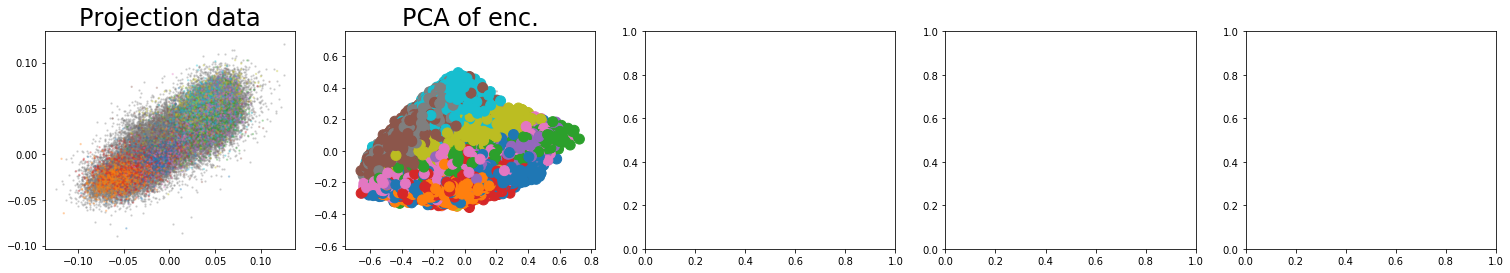

In [26]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [27]:
from tfumap.paths import MODEL_DIR

In [28]:
batch = 0; epoch = 0
N_EPOCHS = 10
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

In [29]:
# early stopping parameters
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
last_improvement = 0 # delta between current batch, and the last batch that was an improvement
best_saved_acc = 0 # best accuracy on valid data that has been checkpointed
best_saved_batch = 0 # batch number for last good batch
max_reinitialize_delta = .01 # minimum loss in accuracy resulting in reinitialized weights
plot_frequency = 2500 # how frequently to plot
save_frequency = 2500 # how frequently to save batches
early_stopping = False
# where to save checkpoints
cpt_path = MODEL_DIR / 'semisupervised' / dataset / datestring

No objects to concatenate


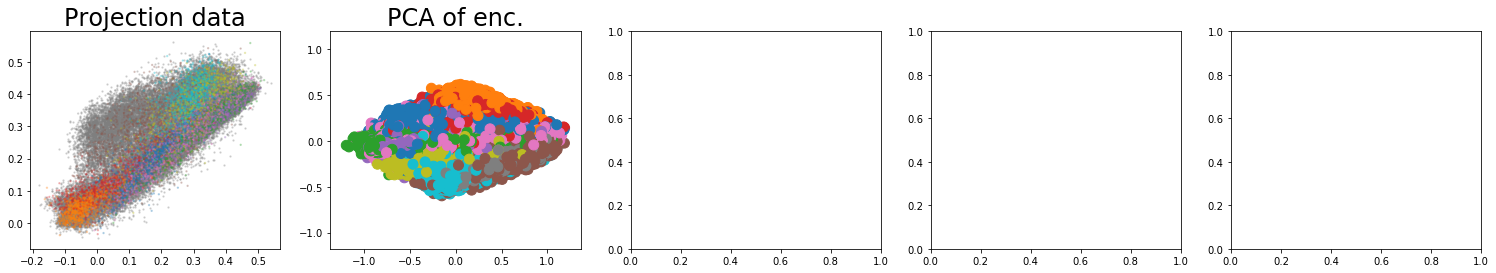

batch: 0 | train acc: 0.105 | val acc: 0.108
tf.Tensor(0.108, shape=(), dtype=float32) -0.01
saving weights
No objects to concatenate


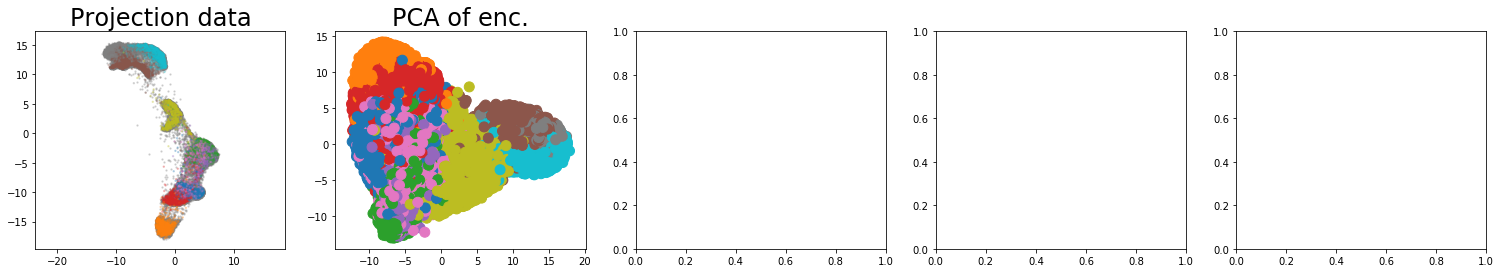

batch: 2500 | train acc: 0.707 | val acc: 0.708
tf.Tensor(0.70795363, shape=(), dtype=float32) 0.09800000280141831
saving weights
No objects to concatenate


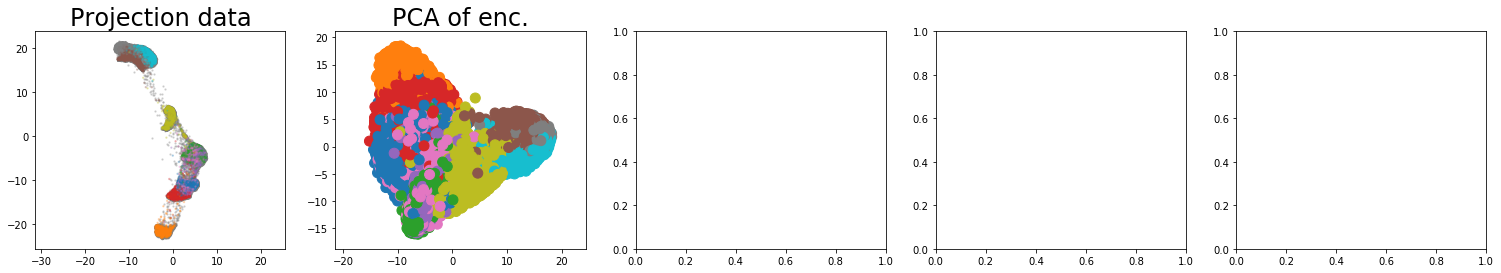

batch: 5000 | train acc: 0.7426 | val acc: 0.7416
tf.Tensor(0.7415719, shape=(), dtype=float32) 0.6979536318778992
saving weights
No objects to concatenate


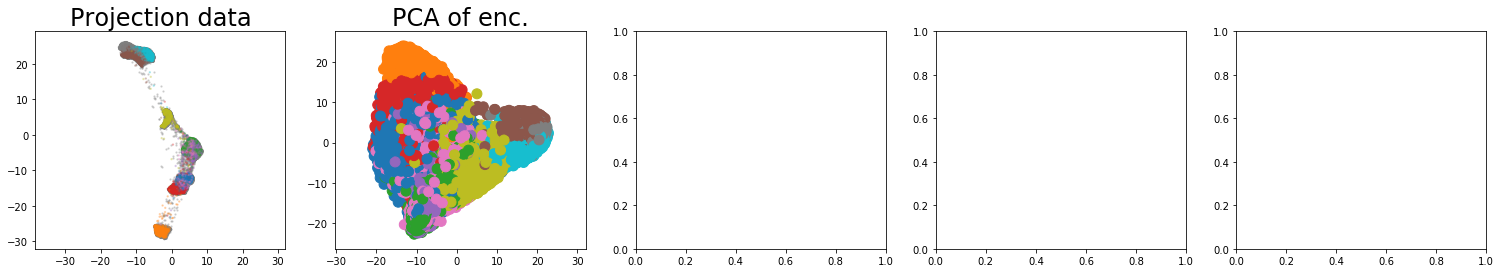

batch: 7500 | train acc: 0.7591 | val acc: 0.7566
tf.Tensor(0.7566428, shape=(), dtype=float32) 0.7315719032287598
saving weights


No objects to concatenate


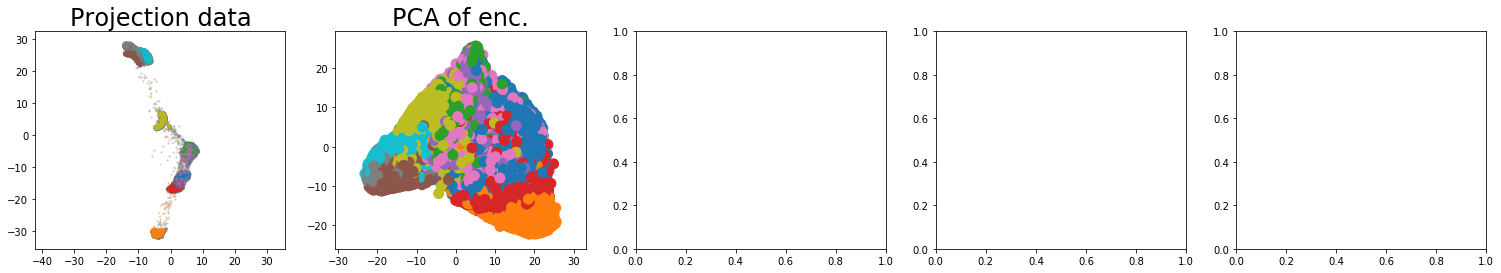

batch: 10000 | train acc: 0.769 | val acc: 0.7657
tf.Tensor(0.76566166, shape=(), dtype=float32) 0.7466428184509277
saving weights
No objects to concatenate


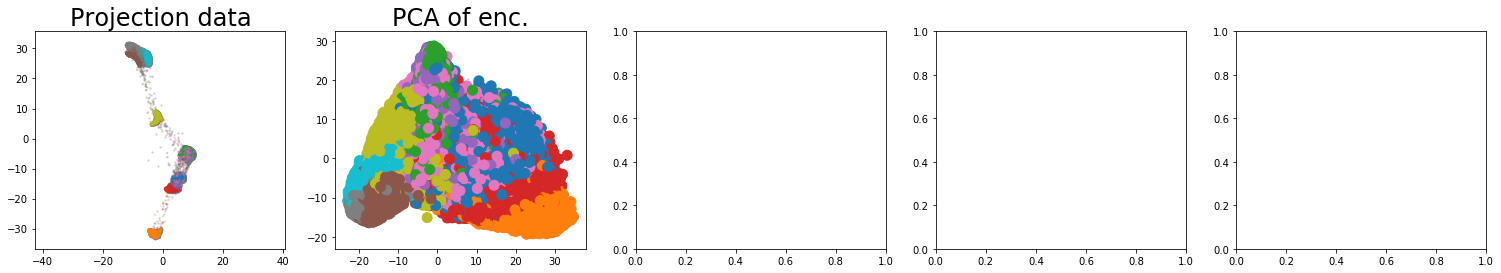

batch: 12500 | train acc: 0.7758 | val acc: 0.7716
tf.Tensor(0.7716382, shape=(), dtype=float32) 0.7556616568565369
saving weights
No objects to concatenate


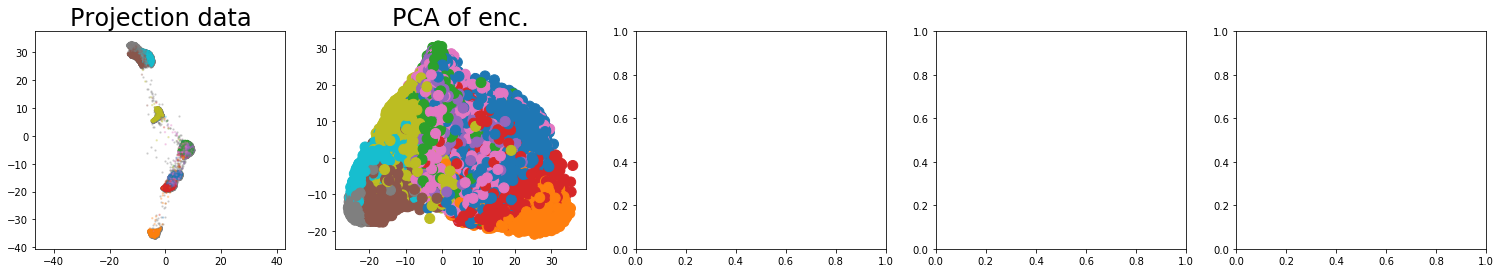

batch: 15000 | train acc: 0.7811 | val acc: 0.7762
tf.Tensor(0.77624583, shape=(), dtype=float32) 0.7616382145881653
saving weights
No objects to concatenate


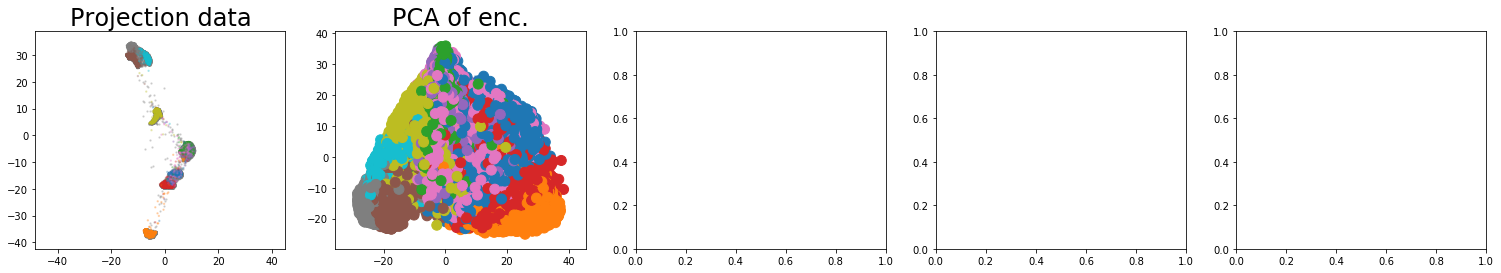

batch: 17500 | train acc: 0.7854 | val acc: 0.7798
tf.Tensor(0.77983236, shape=(), dtype=float32) 0.7662458324432373
saving weights


No objects to concatenate


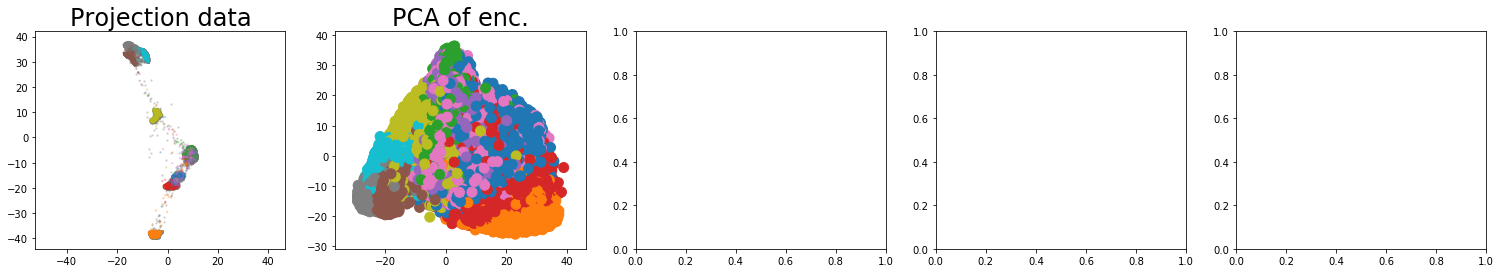

batch: 20000 | train acc: 0.7888 | val acc: 0.7827
tf.Tensor(0.7826874, shape=(), dtype=float32) 0.7698323631286621
saving weights
No objects to concatenate


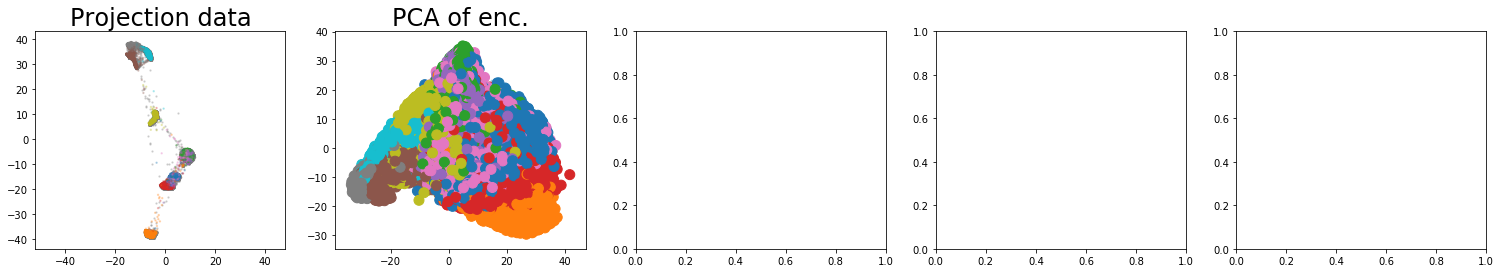

batch: 22500 | train acc: 0.7918 | val acc: 0.7852
tf.Tensor(0.78518236, shape=(), dtype=float32) 0.7726874256134033
saving weights
No objects to concatenate


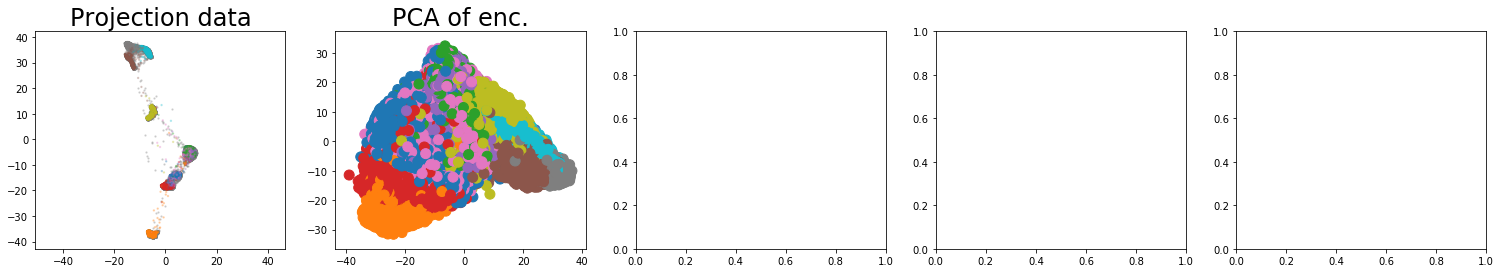

batch: 25000 | train acc: 0.7943 | val acc: 0.7873
tf.Tensor(0.78733385, shape=(), dtype=float32) 0.7751823568344116
saving weights
No objects to concatenate


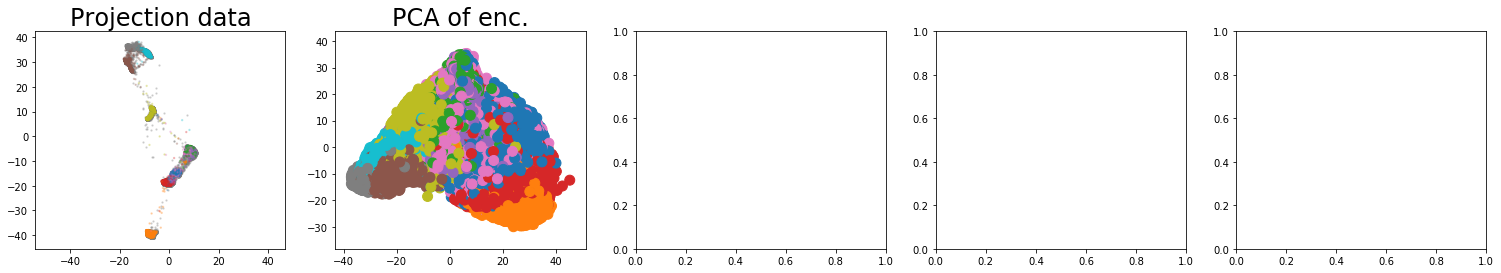

batch: 27500 | train acc: 0.7985 | val acc: 0.7912
tf.Tensor(0.79116994, shape=(), dtype=float32) 0.7773338460922241
saving weights


No objects to concatenate


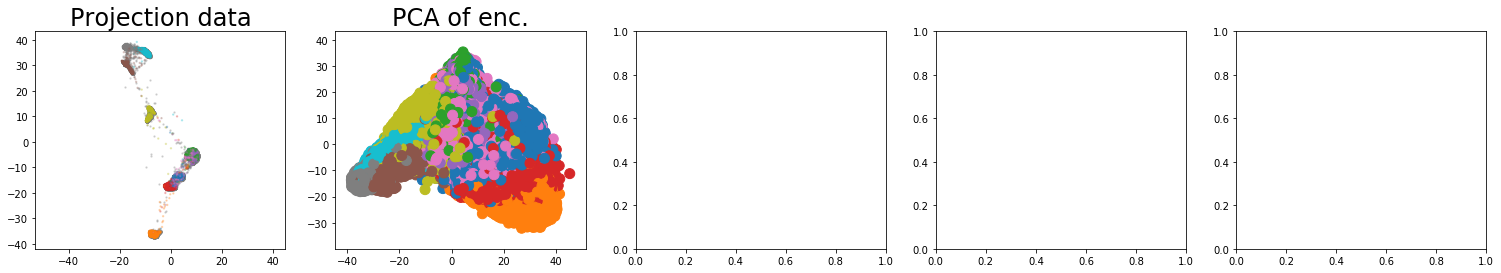

batch: 30000 | train acc: 0.8053 | val acc: 0.7975
tf.Tensor(0.79746056, shape=(), dtype=float32) 0.7811699414253235
saving weights
No objects to concatenate


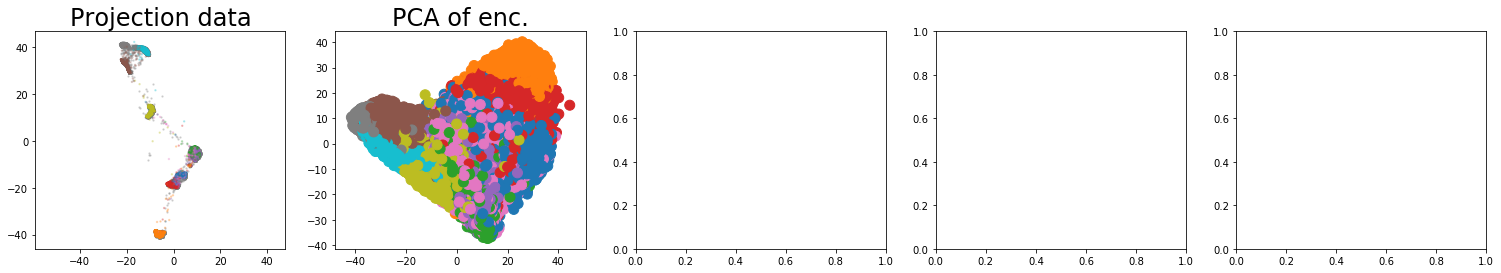

batch: 32500 | train acc: 0.8111 | val acc: 0.8028
tf.Tensor(0.80282784, shape=(), dtype=float32) 0.7874605560302734
saving weights
No objects to concatenate


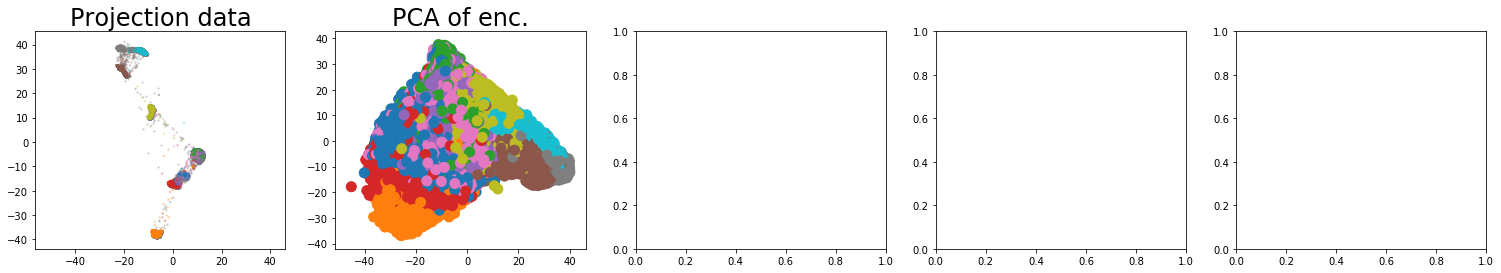

batch: 35000 | train acc: 0.8162 | val acc: 0.8075
tf.Tensor(0.8074837, shape=(), dtype=float32) 0.7928278350830078
saving weights
No objects to concatenate


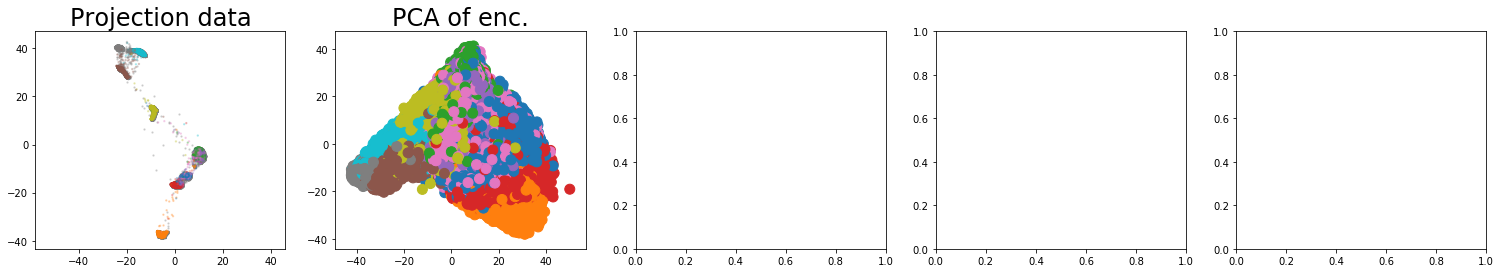

batch: 37500 | train acc: 0.8208 | val acc: 0.8116
tf.Tensor(0.8115656, shape=(), dtype=float32) 0.7974836730957031
saving weights


No objects to concatenate


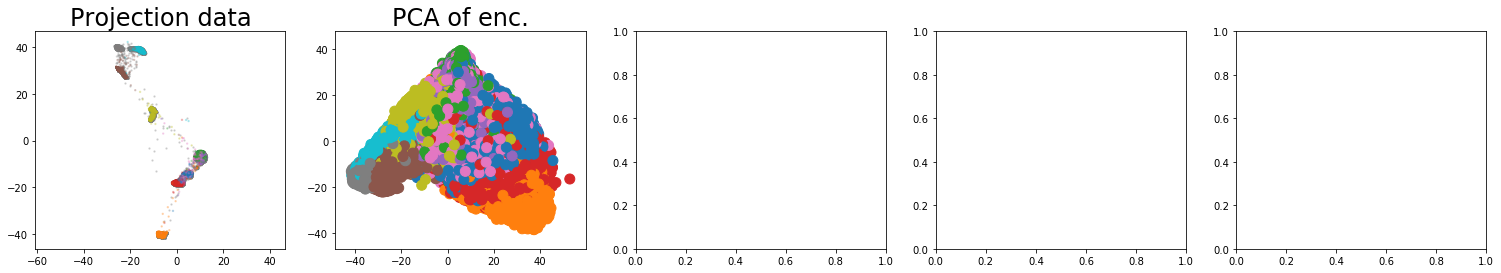

batch: 40000 | train acc: 0.8249 | val acc: 0.8153
tf.Tensor(0.8152679, shape=(), dtype=float32) 0.8015655779838562
saving weights
No objects to concatenate


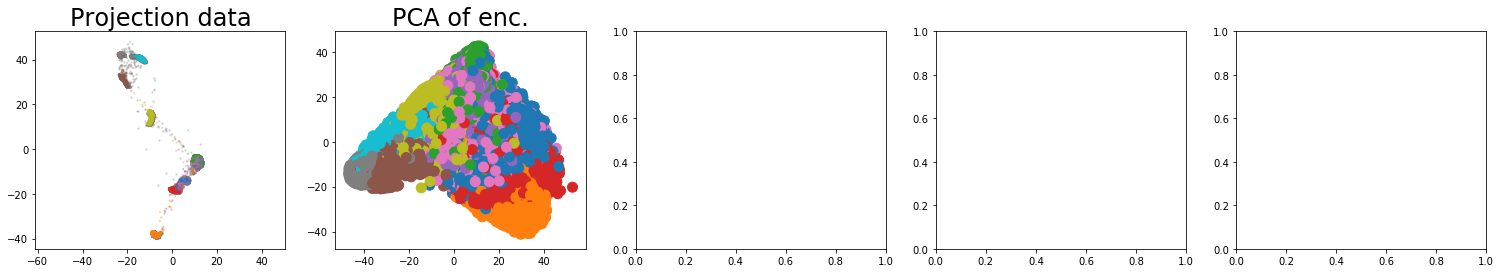

batch: 42500 | train acc: 0.8286 | val acc: 0.8186
tf.Tensor(0.81860363, shape=(), dtype=float32) 0.8052679204940796
saving weights
No objects to concatenate


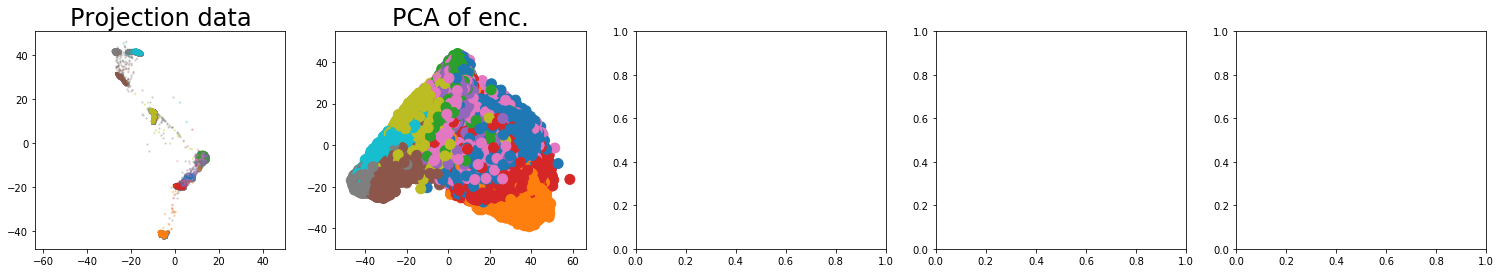

batch: 45000 | train acc: 0.832 | val acc: 0.8216
tf.Tensor(0.82159585, shape=(), dtype=float32) 0.8086036348342895
saving weights
No objects to concatenate


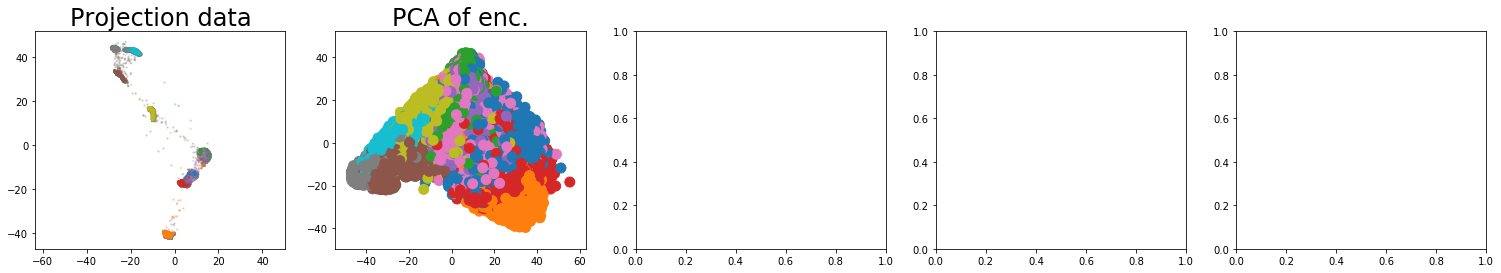

batch: 47500 | train acc: 0.835 | val acc: 0.8243
tf.Tensor(0.8242717, shape=(), dtype=float32) 0.8115958476066589
saving weights


No objects to concatenate


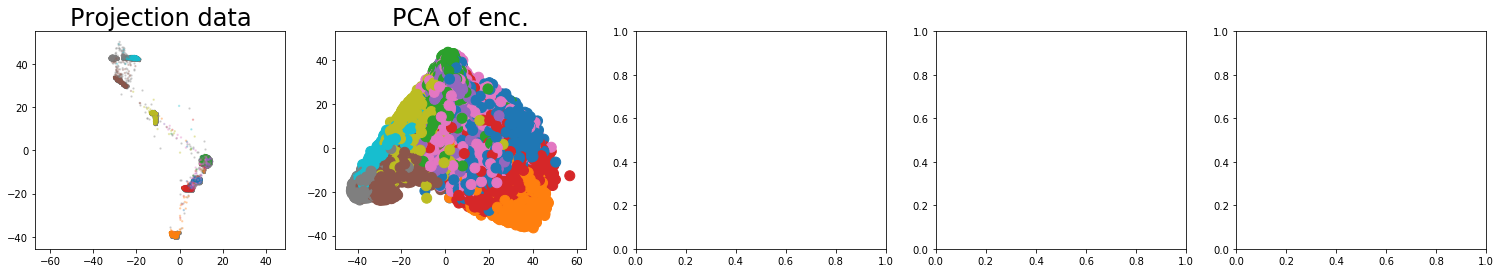

batch: 50000 | train acc: 0.8378 | val acc: 0.8267
tf.Tensor(0.8267194, shape=(), dtype=float32) 0.8142716789245605
saving weights
No objects to concatenate


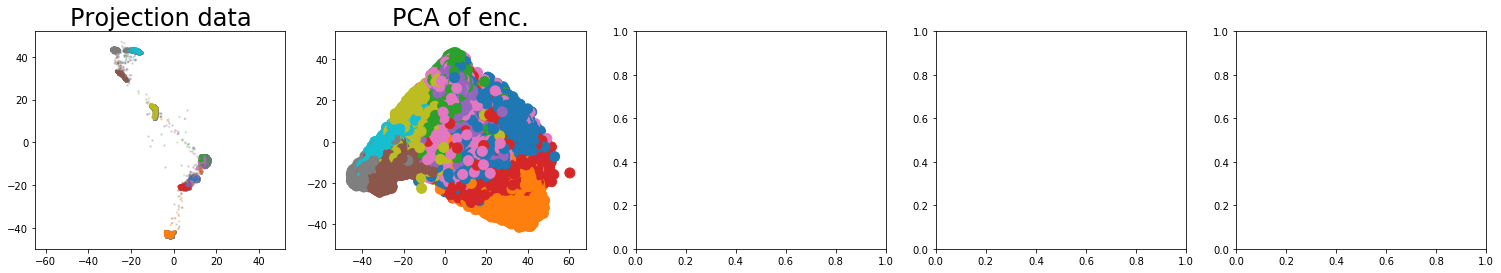

batch: 52500 | train acc: 0.8404 | val acc: 0.8289
tf.Tensor(0.82890964, shape=(), dtype=float32) 0.8167194032669067
saving weights
No objects to concatenate


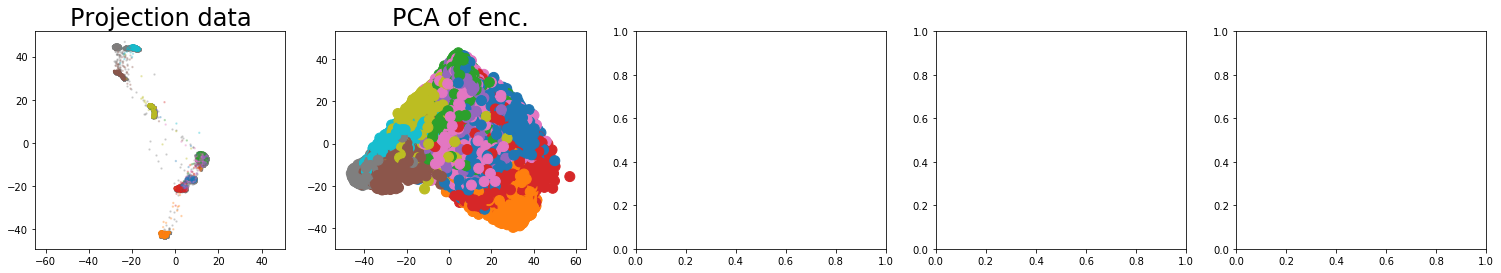

batch: 55000 | train acc: 0.8427 | val acc: 0.8309
tf.Tensor(0.83091563, shape=(), dtype=float32) 0.8189096355438232
saving weights
No objects to concatenate


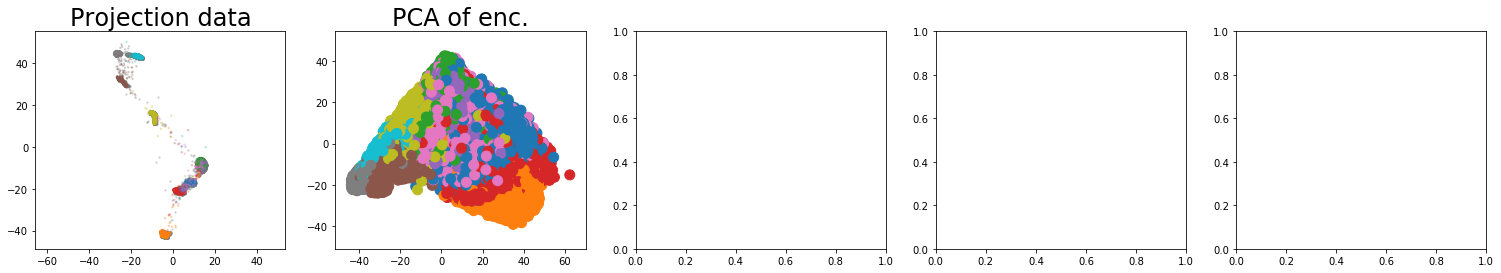

batch: 57500 | train acc: 0.8449 | val acc: 0.8328
tf.Tensor(0.8328378, shape=(), dtype=float32) 0.820915629863739
saving weights


No objects to concatenate


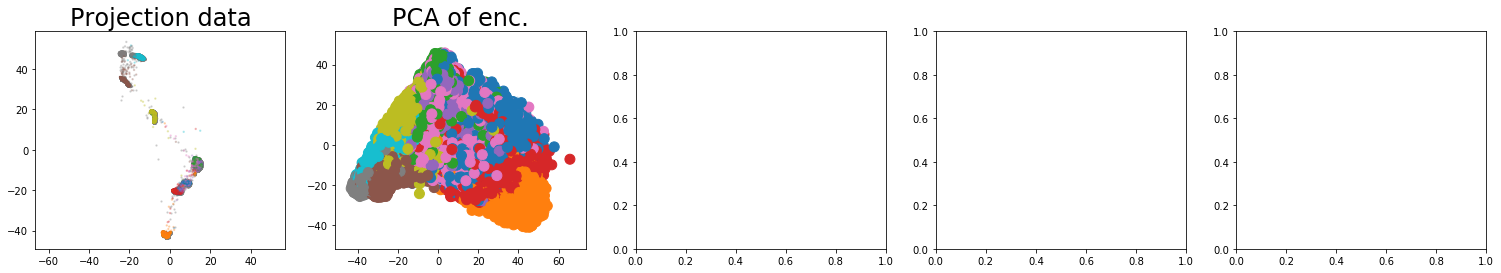

batch: 60000 | train acc: 0.847 | val acc: 0.8346
tf.Tensor(0.8345961, shape=(), dtype=float32) 0.8228378200531006
saving weights
No objects to concatenate


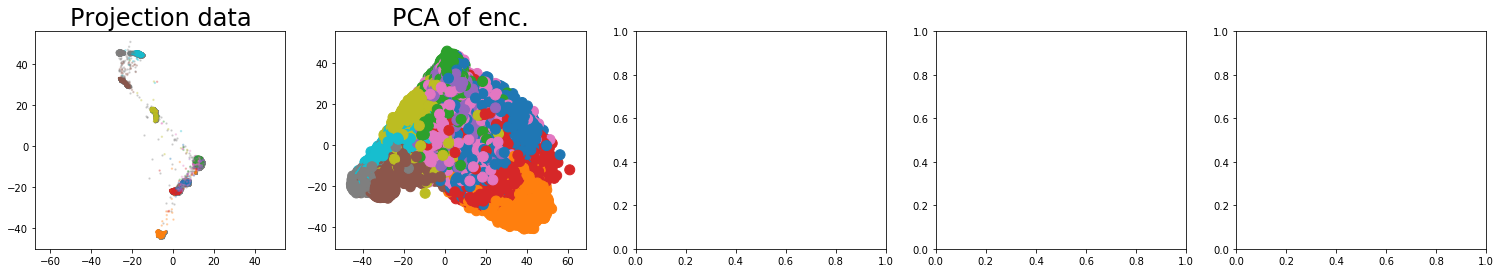

batch: 62500 | train acc: 0.8489 | val acc: 0.8363
tf.Tensor(0.8362548, shape=(), dtype=float32) 0.8245960974693298
saving weights
No objects to concatenate


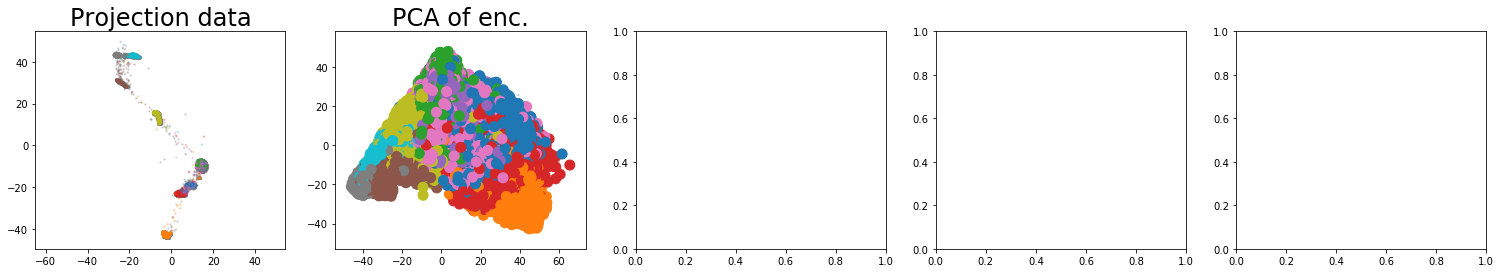

batch: 65000 | train acc: 0.8507 | val acc: 0.8377
tf.Tensor(0.83774465, shape=(), dtype=float32) 0.8262547755241394
saving weights
No objects to concatenate


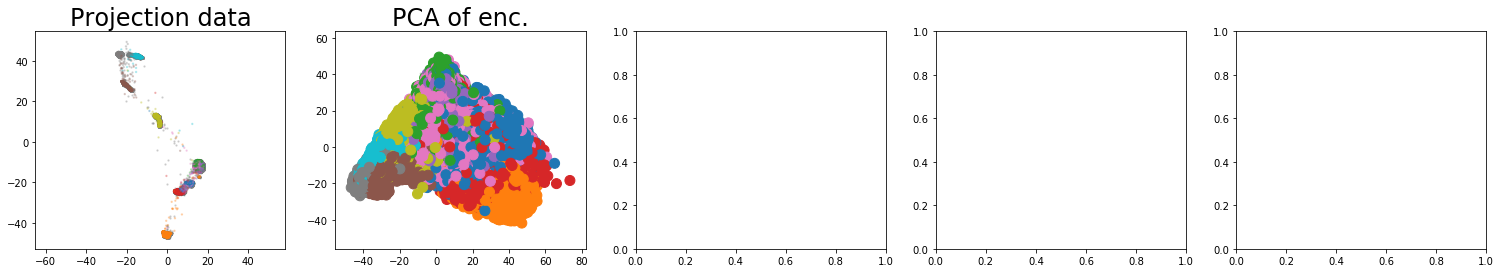

batch: 67500 | train acc: 0.8524 | val acc: 0.8392
tf.Tensor(0.8391726, shape=(), dtype=float32) 0.8277446532249451
saving weights


In [ ]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(
            batch_to=X_train[batch_to], batch_from=X_train[batch_from], X=X, y=y
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        """model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )"""
        
        # plot results
        if batch % plot_frequency == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "batch: {} | train acc: {} | val acc: {}".format(
                    str(batch),
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )
        
        #### save network
        if batch % save_frequency == 0:
            print(val_acc , (best_saved_acc - max_reinitialize_delta))
            if val_acc > best_saved_acc:
                # save weights
                print('saving weights')
                model.encoder.save_weights((cpt_path / 'encoder').as_posix())
                model.embedder.save_weights((cpt_path / 'embedder').as_posix())
                model.classifier.save_weights((cpt_path /  'classifier').as_posix())
                best_saved_acc = val_acc.numpy()
                # save batch number
                best_saved_batch = copy.deepcopy(batch)
            
            elif val_acc < (best_saved_acc - max_reinitialize_delta):
                # reload weights
                print('reloading weights')
                model.encoder.load_weights((cpt_path /  'encoder').as_posix())
                model.embedder.load_weights((cpt_path /  'embedder').as_posix())
                model.classifier.load_weights((cpt_path /  'classifier').as_posix())
                
                # reset batch
                batch = copy.deepcopy(best_saved_batch)
                # reset optimizer
                for var in model.optimizer.variables():
                    var.assign(tf.zeros_like(var))
                    
                # continue on with newly updated batch (past early stopping)
                continue
        
        #### early stopping
        # if there is an imporovement, set new best score
        if val_acc > best_acc + min_delta:
            last_improvement = 0
            best_acc = val_acc
        else:
            # if model has not improved and patience has been surpassed, quit
            if last_improvement>= patience:
                print('Early stopping')
                early_stopping = True
                break
            else:
                last_improvement+=1
            
        batch += 1
    if early_stopping:
        break

In [ ]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

In [ ]:
loss_df.to_pickle(cpt_path/'loss_df')

In [ ]:
valid_acc = loss_df[
    (loss_df.group.values == "valid") & (loss_df.variable.values == "classif_acc")
].val.values

In [ ]:
plt.semilogx(valid_acc)

In [ ]:
# inspect memory footprint

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ["In", "Out", "exit", "quit", "get_ipython", "ipython_vars"]

# Get a sorted list of the objects and their sizes
sorted(
    [
        (x, sys.getsizeof(globals().get(x)))
        for x in dir()
        if not x.startswith("_") and x not in sys.modules and x not in ipython_vars
    ],
    key=lambda x: x[1],
    reverse=True,
)

In [ ]:
import sys
from pympler.asizeof import asizeof

In [ ]:
sys.getsizeof(PUMAP)